**Introduction**
Housing prices are based on a variety of factors, and fluctuate with the health of the economy. However, there should always be things about a home that intrinsically make it higher value than others. Removing economic fluctuations, what makes a house worth more than another, and how can we predict the value of a house? 

<ins>Goal:</ins> Predict housing prices based on a combination of attributes.

To address this question, we will be using a comprehensive dataset that includes various attributes of residential properties. The dataset will include information on property size, architectural features, the presence of amenities (such as parking or whether the house is near the mainroad), and infrastructures within the house. By analyzing these variables and comparing the non-economic factors, we aim to identify what variables have the greatest influence on price prediction, that can be used to predict house prices.

**Methods**
Our base model will be a multivariate regression with our quantitative variables that are known to increase house value (area, bedrooms, bathroom, stories). It will involve a mixture of different types of plots, correlation analysis and regression model. We will be comparing the effect of other categorical variables (whether or not the house has a basement, heating, air conditioning, etc.) to identify the most relevant predictor variables that significantly affect housing prices. Then, we will use 1 to 2 categorical variables that best increase the accuracy of the model from the last step to predict the house prices. Once the model is complete, we will visualize the results with a scatterplot.

**Preliminary Exploratory Data Analysis**

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(readxl)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)
set.seed(2023)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
url <- "https://raw.githubusercontent.com/chwu01/DSCI-Group-Project/main/data/Housing.csv?token=GHSAT0AAAAAACJLPUGVZAVJVT4ABCKVY53KZJ4B4RQ"
housing <- read_csv(url)

housing <- housing |>
    mutate(furnishingstatus = as_factor(furnishingstatus),
          mainroad = as_factor(mainroad),
          guestroom = as_factor(guestroom),
          basement = as_factor(basement),
          hotwaterheating = as_factor(hotwaterheating),
          airconditioning = as_factor(airconditioning),
          prefarea = as_factor(prefarea))

housing

Rows: 545 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): mainroad, guestroom, basement, hotwaterheating, airconditioning, pr...
dbl (6): price, area, bedrooms, bathrooms, stories, parking

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>
13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished
1750000,3850,3,1,2,yes,no,no,no,no,0,no,unfurnished


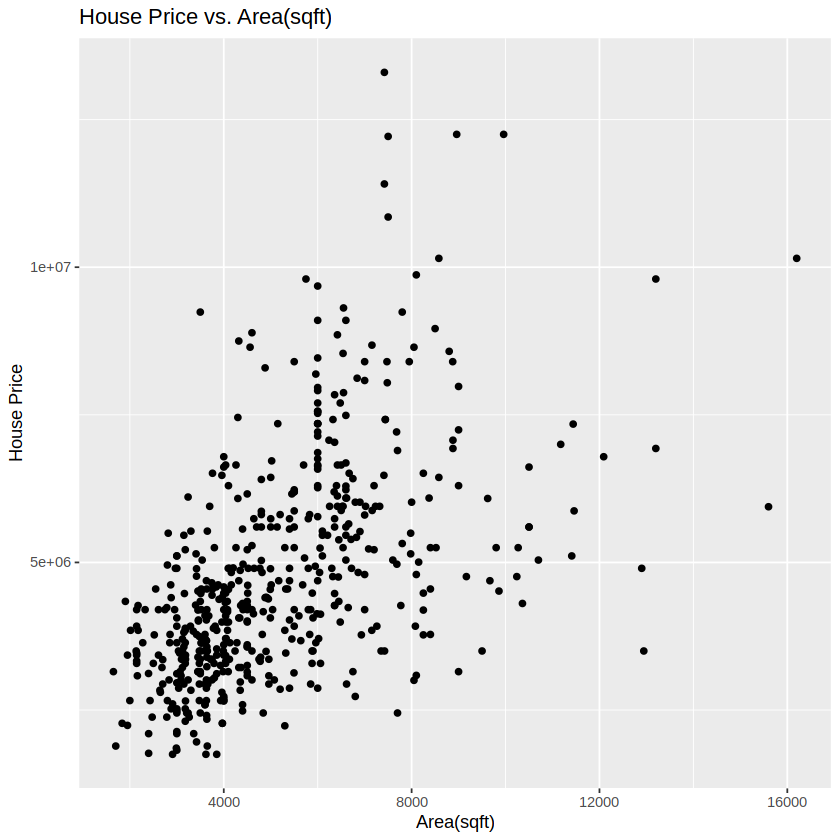

In [3]:
#Scatterplot for price vs. area
housing_plot <- housing|>
    ggplot(aes(x = area, y = price))+
    geom_point()+
    labs(x = "Area(sqft)", y = "House Price")+
    ggtitle("House Price vs. Area(sqft)")
housing_plot

**Initial Observations:** We can see from the plot above that generally, price increases with area, although there is significant variability. There may be other variables at play that are influencing price, beyond just area. For example, house price might go up with the number of bedrooms included, as it would be able to house more people.

In [4]:
# Checking for NA values

housing_check_na <- housing |>
    summarize(check_for_na = sum(is.na(housing)))

housing_check_na

check_for_na
<int>
0


**How does number of bedrooms affect price?**

In [5]:
# Checking the spread of number of bedrooms in the dataset after splitting data

housing_split_bedrooms <- initial_split(housing, prop = 0.75, strata = bedrooms)
housing_train_bedrooms <- training(housing_split_bedrooms)
housing_test_bedrooms <- testing(housing_split_bedrooms) 

housing_bedroom_count <- housing_train_bedrooms |>
    group_by(bedrooms) |>
    summarize(observations = n())

housing_bedroom_count

bedrooms,observations
<dbl>,<int>
1,2
2,101
3,225
4,73
5,6
6,1


In [6]:
# Dividing area into bins to examine the distribution of house square footage

housing_area_bins <- housing_train_bedrooms |>
    select(price, area, bedrooms)

breaks <- c(0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000)
tags <- c("0-1000", "1000-2000", "2000-3000", "3000-4000", "4000-5000", "5000-6000", "6000-7000", "7000-8000", "8000-9000", "9000-10000",
          "10000-11000", "11000-12000", "12000-13000", "13000-14000", "14000-15000", "15000-16000", "16000-17000")

group_tags <- cut(housing_area_bins$area, breaks = breaks, include.lowest = TRUE, right = FALSE, labels = tags)

# group_tags

housing_area_buckets <- housing_train_bedrooms |>
    select(price, area) |>
    mutate(area_bucket = group_tags) |>
    group_by(area_bucket) |>
    summarize(number_of_houses = n())

housing_area_buckets

area_bucket,number_of_houses
<fct>,<int>
1000-2000,6
2000-3000,32
3000-4000,106
⋮,⋮
13000-14000,2
15000-16000,1
16000-17000,1


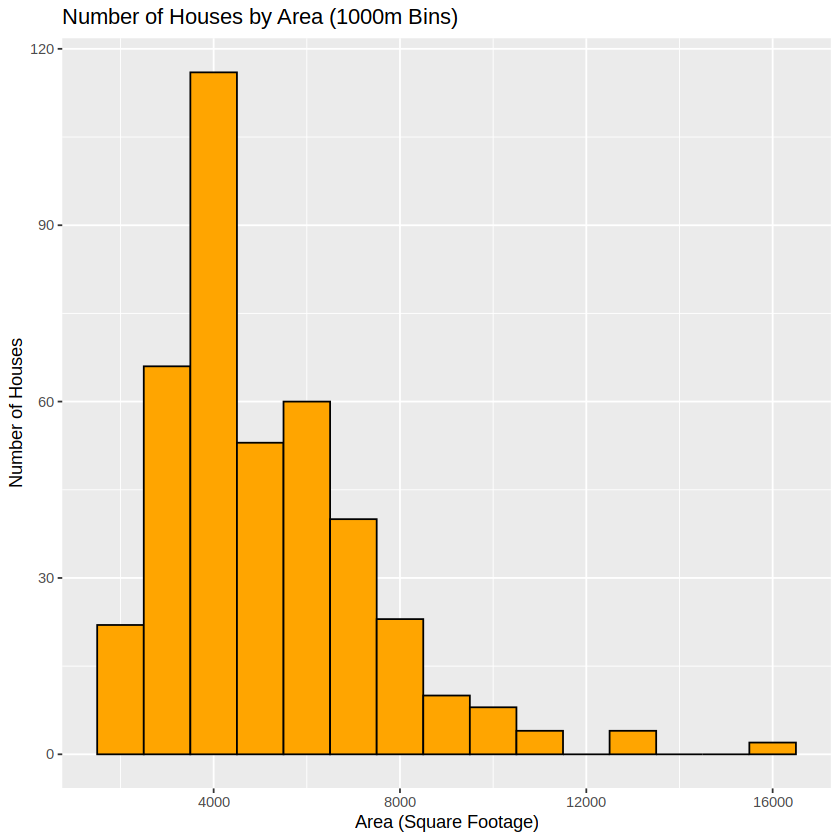

In [7]:
# Visualizing above in a histogram (using training data only)

number_of_houses_by_area <- housing_train_bedrooms |>
    ggplot(aes(x = area)) +
    geom_histogram(binwidth = 1000, colour = "black", fill = "orange") +
    ggtitle("Number of Houses by Area (1000m Bins)") +
    labs(x = "Area (Square Footage)", y = "Number of Houses")

number_of_houses_by_area

**Initial Observations:** There are significantly more observations of houses less than 8000 square feet. It's likely that our predictive model will be much more accurate within that range. Going beyond 8000 square feet will likely decrease the accuracy because there is so little data to train with.

**How does furnishing status affect housing price?**

In [8]:
# Splitting data based on its furnishing status
housing_split_furnishingstatus <- initial_split(housing, prop = 0.75, strata = furnishingstatus)
housing_train_furnishingstatus <- training(housing_split_furnishingstatus)
housing_test_furnishingstatus <- testing(housing_split_furnishingstatus) 

# Summarize obeservation
housing_fs_count <- housing_train_furnishingstatus |>
                      group_by(furnishingstatus) |>
                      summarize(count = n(),
                          mean_area = mean(area, na.rm = TRUE),
                          mean_price = mean(price, na.rm = TRUE),
                          check_na = sum(is.na(area) | is.na(price)))

housing_fs_count

furnishingstatus,count,mean_area,mean_price,check_na
<fct>,<int>,<dbl>,<dbl>,<int>
furnished,105,5757.486,5633567,0
semi-furnished,170,5197.112,4915750,0
unfurnished,133,4649.203,3906158,0


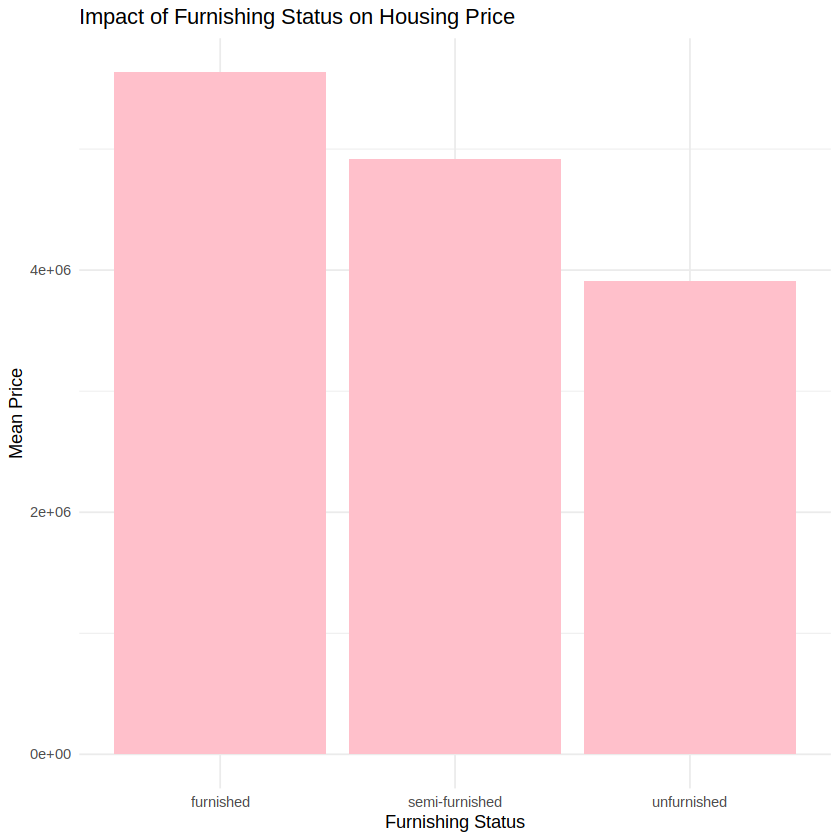

In [9]:
# Visualizing results

housing_fs_bar <- housing_fs_count|>
    ggplot(aes(x = furnishingstatus, y = mean_price)) +
    geom_bar(stat = "identity", fill = "pink") +
    labs(title = "Impact of Furnishing Status on Housing Price",
        x = "Furnishing Status",
        y = "Mean Price") +
    theme_minimal()
housing_fs_bar

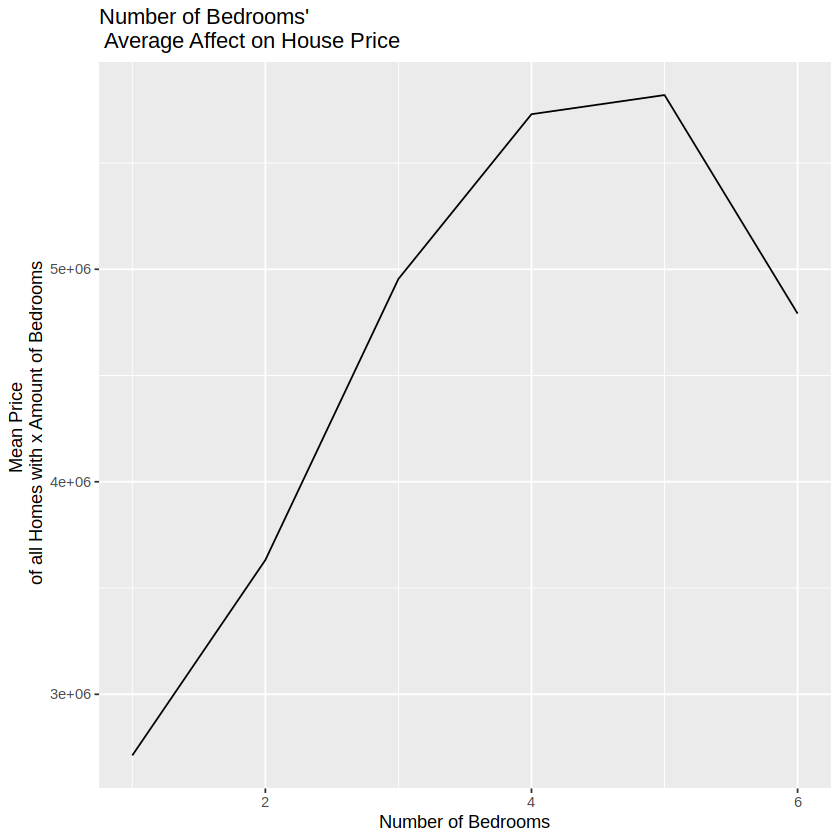

In [10]:
mean_housing_df <- housing |>
    group_by(bedrooms) |>
    mutate(mean_price_per_bedroom = mean(price))

housing_plot <- mean_housing_df |>
    ggplot(aes(x = bedrooms, y = mean_price_per_bedroom)) +
        geom_line() +
        labs(title = "Number of Bedrooms'\n Average Affect on House Price", x = "Number of Bedrooms", y = "Mean Price \n of all Homes with x Amount of Bedrooms")
housing_plot

### Pattern
In general, it seems that the number of bedrooms generally correlates with a higher priced home. So there is a strong relationship.  However, oddly enough it drops off after 5 bedrooms for an unknown reason.  This may be something we need to look into within our analysis
## Figuring out What Plays a Big Role in the Price other than Area

[1] 6678000     NaN 7682500 4651500 6090000     NaN 5212846 2537500 5766056
[10] 4571000 5048107 3777594 6285239

[1] "MGBH" "GBH"  "MBH"  "BH"   "MGH"  "GH"   "MH"   "H"    "MGB"  "GB"  
[11] "MB"   "B"    "MG"

Warning message:
“Removed 2 rows containing missing values (`position_stack()`).”


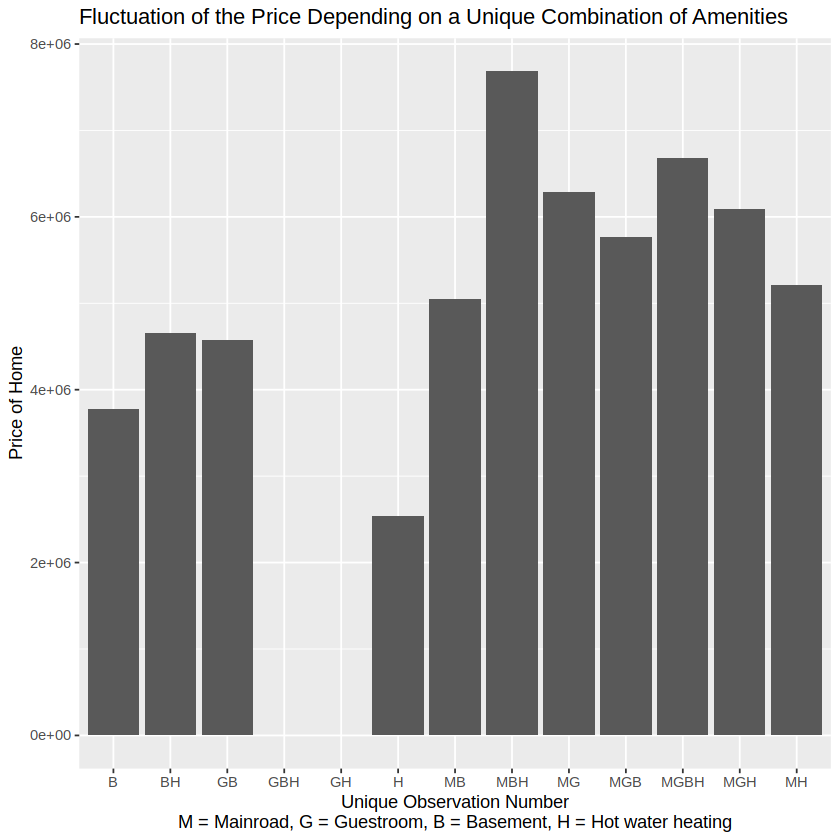

In [11]:
values <- c("yes", "no")
combinations <- expand.grid(
    Var1 = values,
    Var2 = values,
    Var3 = values,
    Var5 = values,
    Var6 = values
)

mean_price_list <- vector()
combo_name_list <- vector()
column_names <- c("combo_type", "price")
avg_price_amenities <- data.frame(matrix(ncol = length(column_names)))

for (i in seq_along(housing)) {
    
    combination_price <- housing |>
        filter(mainroad == combinations[i, 1] & guestroom == combinations[i, 2] & basement == combinations[i, 3] & hotwaterheating == combinations[i, 4]) |>
        summarize(amount = mean(price, na.rm = TRUE))
    
    mean_price <- as.double(combination_price$amount)
    combo_name <- ""
    
    if (combinations[i, 1] == "yes") {
    combo_name <- paste0(combo_name, "M")
    } 
    if (combinations[i, 2] == "yes") {
    combo_name <- paste0(combo_name, "G")
    } 
    if (combinations[i, 3] == "yes") {
    combo_name <- paste0(combo_name, "B")
    } 
    if (combinations[i, 4] == "yes") {
    combo_name <- paste0(combo_name, "H")
    } 
    if (combo_name == "") {
    combo_name <- "None"
    }

    mean_price_list = c(mean_price_list, mean_price)
    combo_name_list = c(combo_name_list, combo_name)
}

mean_price_list
combo_name_list

avg_price_amenities <- data.frame(
    price = mean_price_list,
    combo_type = combo_name_list)

bar_graph <- avg_price_amenities |>
    ggplot(aes(x = combo_type, y = price)) +
        geom_bar(stat = "identity") +
        labs(title = "Fluctuation of the Price Depending on a Unique Combination of Amenities", y = "Price of Home", x = "Unique Observation Number\nM = Mainroad, G = Guestroom, B = Basement, H = Hot water heating")
bar_graph

### Code Explaination
We generate all the possible combinations of amenities a home can have

In [12]:
slice(combinations, 1:3) # There are 16 total combinations in total.  Sliced to save space

Var1,Var2,Var3,Var5,Var6
<fct>,<fct>,<fct>,<fct>,<fct>
yes,yes,yes,yes,yes
no,yes,yes,yes,yes
yes,no,yes,yes,yes


After which we get the mean price of all houses with a certain unique amenities combination.  These are then put into lists which will make up the columns of the data set.
### Patterns
We can see that there is obviously a correlation between the amount of amenities a house has and the ultimate price of it.  Interestingly enough, however, we can see that this isn't always the case, with the mean price of homes with all amenities being cheaper than those with access to the main road, have a basement, and hot water heating.  This is likely to do with other factors such as the total area of the home, as well as its furnishing status among other things.  With the data we have now, there is a possibility that the amount of amenities and the size of the home and/or its furnishing status is related, however, we will need to explore this more deeply later on.

**Expected outcomes**
We anticipate that our analysis will confirm that certain quantitative variables, such as property size and number of bedrooms, will have a positive relationship with the value of the house.  Additionally, we expect that the presence of certain categorical values such as parking and accessibility to mainroad will generally lead to an increase in the housing price. However, subjective factors like the buyer's perception of the value of these amenities could affect how much of an increase there is. These findings are significant because they offer future house owners a more precise understanding of the basic factors influencing house prices.


**Future questions**
- Is it cheaper to buy a house with amenities included or buy one without and install yourself?
- What other variables can impact a house(e.g. age of the house, color)?
